# Response of stationary component of meridional wind

This script generates figure S5: cloud impacts on stationary component of meridional wind response at 300 hPa.

### Load libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

import helper_functions as fct

### Specify months and seasons of the year

In [2]:
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
seasons = ['DJF', 'MAM', 'JJA', 'SON']

### Specify simulations that are analyzed and impacts that are calculated (total response, SST impact, global cloud impact, regional cloud impacts)

In [3]:
# simulations with global cloud changes
runs_glo = ['T1C1', 'T2C2', 'T2C1', 'T1C2']

# simulations with regional cloud changes
runs_reg_TR = ['T1C2TR', 'T1C1TR', 'T2C2TR', 'T2C1TR']
runs_reg_TA = ['T1C2TA', 'T1C1TA', 'T2C2TA', 'T2C1TA']
runs_reg_IO = ['T1C2IO', 'T1C1IO', 'T2C2IO', 'T2C1IO']
runs_reg_WP = ['T1C2WP', 'T1C1WP', 'T2C2WP', 'T2C1WP']
runs_reg_EP = ['T1C2EP', 'T1C1EP', 'T2C2EP', 'T2C1EP']

runs_reg = runs_reg_TR + runs_reg_TA + runs_reg_IO + runs_reg_WP + runs_reg_EP
runs_all = runs_glo + runs_reg

# responses
response_all = ['total', 'SST', 'cloud',
                'cloud TR', 'cloud notTR',
                'cloud TA', 'cloud notTA', 'cloud IO', 'cloud notIO',
                'cloud WP', 'cloud notWP', 'cloud EP', 'cloud notEP']

### Read stream function at 300 hPa

In [4]:
ipath = '../../ICON-NWP_lockedclouds/'
v300 = {}
for run in runs_all:
    print('reading ' + run)
    ifile = 'ICON-NWP_AMIP_' + run + '_3d_mm.nc'
    ncfile = nc.Dataset(ipath + ifile, 'r')
    lats = ncfile.variables['lat'][:].data
    lons = ncfile.variables['lon'][:].data
    levs = ncfile.variables['lev'][:].data
    vwind = ncfile.variables['v'][:].data
    ncfile.close()
    del ifile, ncfile
    
    # calculate stationary component of meridional wind
    # subtract monthly-mean zonal-mean wind from monthly-mean lev-lat-lon wind
    # to get the stationary component
    vstat = vwind - np.nanmean(vwind, axis=3)[:, :, :, None]
    
    # get stationary component of v-wind at 300 hPa
    levind300 = (np.abs(levs-300e2)).argmin() # index of 300 hPa level
    v300[run] = vstat[:, levind300, :, :]
    
    del levs, vwind, vstat, levind300
del run
del ipath

reading T1C1
reading T2C2
reading T2C1
reading T1C2
reading T1C2TR
reading T1C1TR
reading T2C2TR
reading T2C1TR
reading T1C2TA
reading T1C1TA
reading T2C2TA
reading T2C1TA
reading T1C2IO
reading T1C1IO
reading T2C2IO
reading T2C1IO
reading T1C2WP
reading T1C1WP
reading T2C2WP
reading T2C1WP
reading T1C2EP
reading T1C1EP
reading T2C2EP
reading T2C1EP


### Calculate DJF mean

In [5]:
v300_djf = {}
for run in runs_all:
    v300_djf[run] = fct.calcMonthlyandSeasonMean(v300[run],
                                                 months, seasons)[1]['DJF']
del run

del v300

### Calculate response

In [6]:
dv300 = np.full((len(response_all), len(lats), len(lons)),
                np.nan, dtype=float)

# total, SST, cloud
dv300[0, :, :], dv300[1, :, :], dv300[2, :, :] = \
       fct.calc_impacts_timmean(v300_djf['T1C1'], v300_djf['T2C2'],
                                v300_djf['T1C2'], v300_djf['T2C1'])
# regional cloud impacts
for k in range(int(len(runs_reg)/4)):
    _, _, dv300[k*2+3, :, :], dv300[k*2+4, :, :] = \
          fct.calc_3impacts_timmean(v300_djf['T1C1'],
                                    v300_djf['T2C2'],
                                    v300_djf['T1C2'],
                                    v300_djf['T2C1'],
                                    v300_djf[runs_all[4:][k*4]],
                                    v300_djf[runs_all[4:][k*4+1]],
                                    v300_djf[runs_all[4:][k*4+2]],
                                    v300_djf[runs_all[4:][k*4+3]])
del k

### Plot response of stationary component of meridional wind

Shift the longitudes from 0deg...360deg to -90deg...270deg for visualization reasons.

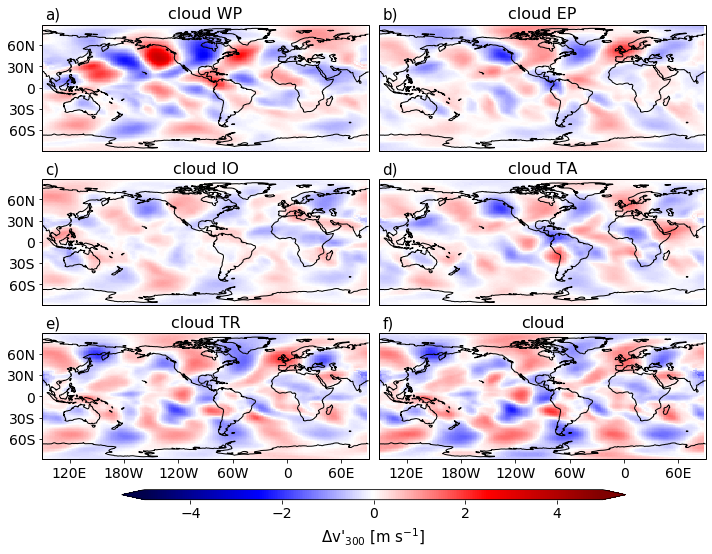

In [7]:
# shift longitudes
dv300_shift, lons_shift = fct.shiftgrid_copy(90., dv300, lons, start=False)

response_plot = ['cloud WP', 'cloud EP',
                 'cloud IO', 'cloud TA',
                 'cloud TR', 'cloud']

proj = ccrs.PlateCarree(central_longitude=-90)
fig, ax = plt.subplots(3, 2, figsize=(10, 7),
                       subplot_kw=dict(projection=proj))
ax = ax.reshape(-1)    
for r in range(ax.shape[0]): # loop over responses
    ax[r].coastlines(rasterized=True)
    ax[r].set_aspect('auto')
    ax[r].tick_params(labelsize=14)
    # set xticks and yticks for latitudes and longitudes
    # xaxis: longitudes
    if r > 3: # last row
        ax[r].set_xticks([-120, -60, 0, 60, 120, 180], crs=ccrs.PlateCarree())
        lon_formatter = LongitudeFormatter(#zero_direction_label=True,
                                            degree_symbol='',
                                            dateline_direction_label=True)
        ax[r].xaxis.set_major_formatter(lon_formatter)
        del lon_formatter
    # yaxis: latitudes
    if r in [0, 2, 4]:
        ax[r].set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
        lat_formatter = LatitudeFormatter(degree_symbol='')
        ax[r].yaxis.set_major_formatter(lat_formatter)
        del lat_formatter
    # cloud impacts
    cf0 = ax[r].pcolormesh(lons_shift, lats,
                           dv300_shift[response_all.index(response_plot[r]), :, :],
                           vmin=-5, vmax=5, cmap='seismic',
                           rasterized=True,
                           transform=ccrs.PlateCarree())
    ax[r].set_title(response_plot[r], fontsize=16)
del r
fig.canvas.draw()
fig.tight_layout()

# colorbar for response
fig.subplots_adjust(bottom=0.08)#(right=0.8)
cbar_ax = fig.add_axes([0.174, 0.0, 0.7, 0.02]) # left,bottom,width,height
cb = fig.colorbar(cf0, cax=cbar_ax, orientation='horizontal', extend='both')
cb.set_label("$\Delta$v'$_{300}$ [m s$^{-1}$]",
             fontsize=15, labelpad=5)
cb.ax.tick_params(labelsize=14)
del cbar_ax, cb, cf0

# a), b) etc for subplots
labs = ['a)', 'b)', 'c)', 'd)', 'e)', 'f)']
for i in range(ax.shape[0]):
    ax[i].text(0.01, 1.02, labs[i], va='bottom', ha='left',
               rotation_mode='anchor', fontsize=15,
               transform=ax[i].transAxes)
del i, labs

fig.savefig('figure_S5.pdf', bbox_inches='tight')
plt.show(fig)
plt.close(fig)
del fig, ax, proj
del response_plot, dv300_shift, lons_shift